In [11]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt


In [2]:
# Initialize the CartPole-v1 environment
env = gym.make('CartPole-v1')

# Extract state and action dimensions
state_dim = env.observation_space.shape[0]  # 4 for CartPole
action_dim = env.action_space.n  # 2 for CartPole (discrete actions)

# Set the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = []
        self.capacity = capacity

    def add(self, experience):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = np.random.choice(len(self.buffer), batch_size, replace=False)
        states = torch.tensor([self.buffer[i][0] for i in batch], dtype=torch.float32).to(device)
        actions = torch.tensor([self.buffer[i][1] for i in batch], dtype=torch.long).to(device)
        rewards = torch.tensor([self.buffer[i][2] for i in batch], dtype=torch.float32).to(device)
        next_states = torch.tensor([self.buffer[i][3] for i in batch], dtype=torch.float32).to(device)
        dones = torch.tensor([self.buffer[i][4] for i in batch], dtype=torch.float32).to(device)
        return states, actions, rewards, next_states, dones


In [4]:
class ActorSACDiscrete(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorSACDiscrete, self).__init__()
        self.layer1 = nn.Linear(state_dim, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, action_dim)  # Output logits for each action

    def forward(self, state):
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        logits = self.layer3(x)  # Output logits
        action_probs = torch.softmax(logits, dim=-1)  # Convert to probabilities
        return action_probs


In [5]:
class CriticSACDiscrete(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(CriticSACDiscrete, self).__init__()
        self.layer1 = nn.Linear(state_dim, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, action_dim)  # Output Q-values for each action

    def forward(self, state):
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        q_values = self.layer3(x)  # Q-values for each action
        return q_values


In [6]:
class SACAgentDiscrete:
    def __init__(self, state_dim, action_dim, alpha=0.2):
        self.actor = ActorSACDiscrete(state_dim, action_dim).to(device)
        self.critic1 = CriticSACDiscrete(state_dim, action_dim).to(device)
        self.critic2 = CriticSACDiscrete(state_dim, action_dim).to(device)
        
        # Target networks
        self.critic1_target = CriticSACDiscrete(state_dim, action_dim).to(device)
        self.critic2_target = CriticSACDiscrete(state_dim, action_dim).to(device)
        
        # Copy weights to target networks
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target.load_state_dict(self.critic2.state_dict())

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=1e-3)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=1e-3)

        self.replay_buffer = ReplayBuffer()
        self.gamma = 0.99
        self.tau = 0.005
        self.alpha = alpha  # Fixed entropy coefficient
        self.action_dim = action_dim

    def select_action(self, state):
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            action_probs = self.actor(state).detach().cpu().numpy()[0]
            action = np.random.choice(len(action_probs), p=action_probs)  # Sample an action
        return action

    def train(self, batch_size=64):
        if len(self.replay_buffer.buffer) < batch_size:
            return

        # Sample from replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)

        # Critic loss
        with torch.no_grad():
            next_action_probs = self.actor(next_states)
            next_q1 = self.critic1_target(next_states)
            next_q2 = self.critic2_target(next_states)
            
            min_next_q = torch.min(next_q1, next_q2)
            entropy_term = -self.alpha * torch.sum(next_action_probs * torch.log(next_action_probs + 1e-6), dim=1, keepdim=True)
            
            target_q = rewards.unsqueeze(1) + self.gamma * (1 - dones.unsqueeze(1)) * (
                (next_action_probs * min_next_q).sum(dim=1, keepdim=True) + entropy_term
            )

        current_q1 = self.critic1(states).gather(1, actions.long().unsqueeze(1))
        current_q2 = self.critic2(states).gather(1, actions.long().unsqueeze(1))

        critic1_loss = F.mse_loss(current_q1, target_q)
        critic2_loss = F.mse_loss(current_q2, target_q)

        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()

        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()

        # Actor loss
        action_probs = self.actor(states)
        log_probs = torch.log(action_probs + 1e-6)
        q_values1 = self.critic1(states)
        q_values2 = self.critic2(states)
        min_q_values = torch.min(q_values1, q_values2)

        actor_loss = torch.sum(action_probs * (self.alpha * log_probs - min_q_values), dim=1).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self._soft_update(self.critic1, self.critic1_target)
        self._soft_update(self.critic2, self.critic2_target)

    def _soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)


In [7]:
def train_sac(env_name='CartPole-v1', episodes=1000, batch_size=64, warmup_steps=1000):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    sac_agent = SACAgentDiscrete(state_dim, action_dim)
    training_rewards_sac = []

    for episode in range(episodes):
        state, _ = env.reset(seed=42)
        episode_reward = 0
        done = False

        while not done:
            action = sac_agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            sac_agent.replay_buffer.add((state, action, reward, next_state, float(done)))
            state = next_state
            episode_reward += reward

            if len(sac_agent.replay_buffer.buffer) >= warmup_steps:
                sac_agent.train(batch_size=batch_size)

        training_rewards_sac.append(episode_reward)
        print(f"SAC - Episode {episode + 1}: Reward = {episode_reward}")

    return training_rewards_sac


In [8]:
def evaluate_sac(agent, env_name='CartPole-v1', episodes=10):
    env = gym.make(env_name)
    rewards = []

    for episode in range(episodes):
        state, _ = env.reset(seed=42)
        done = False
        episode_reward = 0

        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state

        rewards.append(episode_reward)
        print(f"Evaluation Episode {episode + 1}: Reward = {episode_reward}")

    print(f"Average Reward: {np.mean(rewards)}")
    return rewards


In [9]:
def plot_rewards(rewards, title="SAC Training Rewards"):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Reward per Episode")
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()


SAC - Episode 1: Reward = 19.0
SAC - Episode 2: Reward = 15.0
SAC - Episode 3: Reward = 11.0
SAC - Episode 4: Reward = 15.0
SAC - Episode 5: Reward = 13.0
SAC - Episode 6: Reward = 80.0
SAC - Episode 7: Reward = 21.0
SAC - Episode 8: Reward = 26.0
SAC - Episode 9: Reward = 11.0
SAC - Episode 10: Reward = 22.0
SAC - Episode 11: Reward = 39.0
SAC - Episode 12: Reward = 18.0
SAC - Episode 13: Reward = 15.0
SAC - Episode 14: Reward = 15.0
SAC - Episode 15: Reward = 14.0
SAC - Episode 16: Reward = 16.0
SAC - Episode 17: Reward = 16.0
SAC - Episode 18: Reward = 14.0
SAC - Episode 19: Reward = 24.0
SAC - Episode 20: Reward = 13.0
SAC - Episode 21: Reward = 21.0
SAC - Episode 22: Reward = 13.0
SAC - Episode 23: Reward = 12.0
SAC - Episode 24: Reward = 66.0
SAC - Episode 25: Reward = 23.0
SAC - Episode 26: Reward = 9.0
SAC - Episode 27: Reward = 22.0
SAC - Episode 28: Reward = 16.0
SAC - Episode 29: Reward = 15.0
SAC - Episode 30: Reward = 30.0
SAC - Episode 31: Reward = 18.0
SAC - Episode 32: 

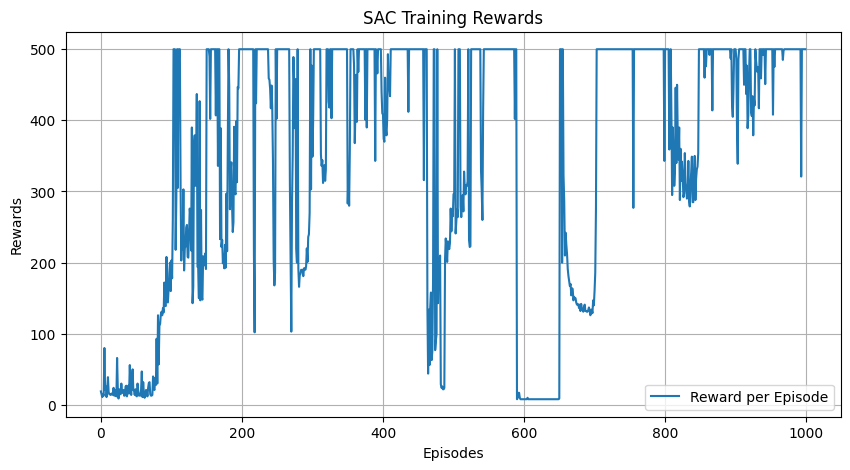

Evaluation Episode 1: Reward = 9.0
Evaluation Episode 2: Reward = 24.0
Evaluation Episode 3: Reward = 24.0
Evaluation Episode 4: Reward = 15.0
Evaluation Episode 5: Reward = 31.0
Evaluation Episode 6: Reward = 14.0
Evaluation Episode 7: Reward = 10.0
Evaluation Episode 8: Reward = 44.0
Evaluation Episode 9: Reward = 23.0
Evaluation Episode 10: Reward = 16.0
Average Reward: 21.0


In [12]:
if __name__ == "__main__":
    # Train SAC Agent
    rewards = train_sac()

    # Plot Training Rewards
    plot_rewards(rewards)

    # Evaluate SAC Agent
    state_dim = 4  # Replace with actual state dimension
    action_dim = 2  # Replace with actual action dimension
    sac_agent = SACAgentDiscrete(state_dim, action_dim)
    evaluate_sac(sac_agent)
